# Solution explained (5 cnot gates)
### by Jian Wang, 2021 May 26th

The cost is 5 cnot gates.

After some trials, I found that the settings below can reduce the circuits to 6 qubits, and it will below the accept energy. 
```python
ElectronicStructureProblem(driver,q_molecule_transformers = [FreezeCoreTransformer(True)])
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,1])
```
There can be a 4 qubits setting, `FreezeCoreTransformer(True,[2])`  however, the energy can not be optimized to acceptance region.  

Using any of the mapper, we can solve the state to a lower energy. Now the only problem is to reduce numbers of cnot gates.  
More cnot gate will help to traverse more corners of the Hilbert space, however, if the solution vector is very simple, we actually don't need that much cnot gates.  
`result.eigenstate` gives us the optimal vector (a $2^6=64$ dimensional vector).  The index i of the `result.eigenstate[i]` orders like `000000,000001,000010,000011,...` trasnlate to `0,1,2,3,...`

```python
wave = result.eigenstate
for i,x in enumerate(wave):
    if abs(x) < 1e-15:
        pass
    else:
        print(i,x,np.sqrt(abs(x)**2), "{0:b}".format(i) )
```
will print
```python
3 (0.991486984-4.34830214e-16j) 0.991486984 11
6 (-0.0175540687+2.51279577e-17j) 0.0175540687 110
14 (-0.0284034777-1.39051442e-18j) 0.0284034777 1110
30 (-0.0283255203-7.36309535e-17j) 0.0283255203 11110
60 (-0.111802457+7.88531812e-18j) 0.111802457 111100
62 (0.0503640117+5.66138084e-17j) 0.0503640117 111110
```
It is surpising that in a total dimension of 64, the optimal vector occupies only 6 basis.  
Now the problem becomes how to create a quantum circuit from state `|000000>`  to  
`0.991 |000011> - 0.0175 |000110> - 0.0284 |00110> + ...`

* from 110,1110,11110 to 111110, each time the basis add one "up" state, this can be constructed via a controlled rotation gate.   
* from 111110 to 111100, it is also a controlled rotation  
* qubit[0] and qubit\[1\] always opposite to each other, this is a typical structure of 2-qubit entanglement, it can be done by a rotation plus cnot, similar to hadama plus cnot, but with unequal weights.  the `x` gate aims to rotate from `a|00>+b|11>` to `a|01> + b|10>` 


In [1]:
from qiskit_nature.drivers import PySCFDriver
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()
print(qmolecule.num_molecular_orbitals,qmolecule.core_orbitals)

6 [0]


# Clean solution

In [15]:
# WRITE YOUR CODE BETWEEN THESE LINES - START

from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
#from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

problem = ElectronicStructureProblem(driver,\
                                     q_molecule_transformers = [FreezeCoreTransformer(True)])
second_q_ops = problem.second_q_ops()
main_op = second_q_ops[0]
mapper_type = 'ParityMapper'
mapper = ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,1])

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

ansatz_type = "Custom" 
########################################################################## Define the variational parameter
theta = Parameter('a')
n = qubit_op.num_qubits
# Make an empty quantum circuit
qc = QuantumCircuit(qubit_op.num_qubits)
qubit_label = 0
# Place a Hadamard gate
qc.ry(Parameter('b'),0)
qc.rz(Parameter('bb'),0)
qc.cx(0,2)
qc.x(2)

r23 = Parameter('r23')
qc.ry(r23,3)
qc.cx(2,3)
qc.ry(-r23,3)
qc.rz(Parameter('r23z'),3)

r34 = Parameter('r34')
qc.ry(r34,4)
qc.cx(3,4)
qc.ry(-r34,4)
qc.rz(Parameter('r34z'),4)


r45 = Parameter('r45')
qc.ry(r45,5)
if True:
    qc.cx(4,5)
    qc.ry(-r45,5)
    qc.rz(Parameter('r45z'),5)

r21 = Parameter('r21')
qc.ry(r21,1)
qc.cx(2,1)
qc.ry(-r21,1)
qc.rz(Parameter('r21z'),1)

# Visual separator
# qc.barrier()
# rz rotations on all qubits
qc.rz(theta, range(n))
ansatz = qc
ansatz.compose(init_state, front=True, inplace=True)
########################################################################## End the variational parameter

backend = Aer.get_backend('statevector_simulator')

optimizer_type = 'COBYLA'
optimizer = COBYLA(maxiter=500)


# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, SeaLevel: {} ,Energy: {}, Std: {}".format(eval_count, mean-goalgoal, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters
    


algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)
# WRITE YOUR CODE BETWEEN THESE LINES - END

'Evaluation: 500, SeaLevel: -0.0026723098136809398 ,Energy: -1.0884562697904647, Std: 0.0'

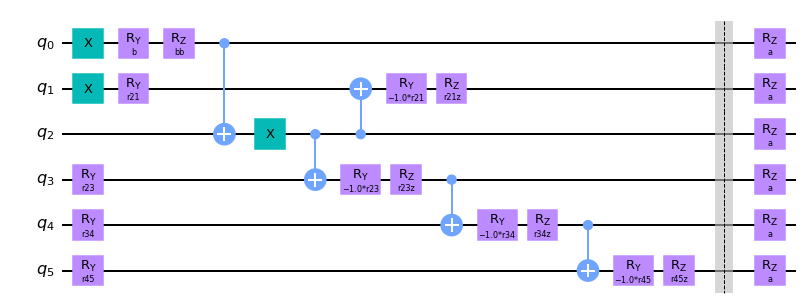

In [16]:
ansatz.draw()

In [17]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 5.
Feel free to submit your answer.

